# **Problema**
**Queremos almacenar en una base de datos propia los datos de niveles de NO2 del aire de Madrid durante el año 2018. El objetivo es que otros departamentos puedan:**
 **- Hacer una visualización de la evolución de la contaminación: gráficas de evolución diaria / mensual, mapas de calor animados, ...**
 **- Hacer análisis de situaciones extraordinarias: días con restricciones, medición de la efectividad de ciertas medidas, ...**

**Los datos están disponibles en el portal de datos abiertos de Madrid. Asegúrate de consultar el PDF con la documentación, te  proporcionará información de utilidad sobre el dataset. Algunos comentarios:**
**- Descarga los datos del año 2018**
**- Solo nos interesan las mediciones sobre el NO2. Puedes descartar las de otros elementos contaminantes**


### *Objetivo 1: Estadístico*
#### **Leer y tratar los datos. Debes dejarlos limpios en el formato que consideres más cómodo para su análisis.**

Vamos a hacer una limpieza de los datos como se nos comenta. En la documentación, vemos que el dato del NO2 es la Magnitud 8, así que filtraremos primero por ahí. Pero antes, vamos a leer todos los archivos, empezando por hacer un DataFrame con todos los datos concatenados. 

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import warnings

warnings.filterwarnings('ignore')

In [96]:
ruta = os.getcwd() + '/2018'
archivos = os.listdir(ruta)
archivos_csv = [archivo for archivo in archivos if archivo.endswith('.csv')] # filtramos solamente para los .csv
# nota: cuando se descargue este notebook, se deben descargar los archivos .csv en una carpeta llamada /2018, como dejaré subido en el repositorio

In [97]:
# concatenamos todos los archivos en un solo DataFrame, teniendo ; como separador
for archivo in archivos_csv:
    df = pd.read_csv(ruta + '/' + archivo, sep=';')
    if archivo == archivos_csv[0]:
        df_t = df
    else:
        df_t = pd.concat([df_t, df])
df_t

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2018,4,1,2.00,V,...,2.0,V,2.00,V,3.00,V,4.00,V,3.00,V
1,28,79,4,1,28079004_1_38,2018,4,2,2.00,V,...,2.0,V,2.00,V,2.00,V,2.00,V,2.00,V
2,28,79,4,1,28079004_1_38,2018,4,3,2.00,V,...,2.0,V,2.00,V,2.00,V,2.00,V,2.00,V
3,28,79,4,1,28079004_1_38,2018,4,4,2.00,V,...,2.0,V,2.00,V,2.00,V,2.00,V,2.00,V
4,28,79,4,1,28079004_1_38,2018,4,5,2.00,V,...,2.0,V,2.00,V,4.00,V,5.00,V,4.00,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,28,79,60,14,28079060_14_6,2018,9,26,57.88,V,...,59.7,V,76.54,V,81.33,V,77.88,V,79.67,V
4496,28,79,60,14,28079060_14_6,2018,9,27,84.71,V,...,103.3,V,70.81,V,34.07,V,12.90,V,36.85,V
4497,28,79,60,14,28079060_14_6,2018,9,28,27.33,V,...,100.7,V,42.17,V,5.14,V,3.50,V,6.10,V
4498,28,79,60,14,28079060_14_6,2018,9,29,43.00,V,...,126.7,V,76.40,V,27.62,V,17.95,V,10.89,V


In [98]:
# filtramos los resultados de la magnitud igual a 8 que es el dióxido de nitrógeno NO2
df_filtrado = df_t[df_t['MAGNITUD'] == 8]
df_filtrado

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
90,28,79,4,8,28079004_8_8,2018,4,1,21.0,V,...,46.0,V,57.0,V,82.0,V,85.0,V,77.0,V
91,28,79,4,8,28079004_8_8,2018,4,2,67.0,V,...,22.0,V,26.0,V,38.0,V,15.0,V,15.0,V
92,28,79,4,8,28079004_8_8,2018,4,3,14.0,V,...,23.0,V,27.0,V,30.0,V,23.0,V,20.0,V
93,28,79,4,8,28079004_8_8,2018,4,4,8.0,V,...,14.0,V,19.0,V,22.0,V,28.0,V,23.0,V
94,28,79,4,8,28079004_8_8,2018,4,5,20.0,V,...,45.0,V,68.0,V,99.0,V,93.0,V,84.0,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,28,79,60,8,28079060_8_8,2018,9,26,16.0,V,...,47.0,V,26.0,V,17.0,V,15.0,V,13.0,V
4406,28,79,60,8,28079060_8_8,2018,9,27,9.0,V,...,28.0,V,47.0,V,71.0,V,109.0,V,74.0,V
4407,28,79,60,8,28079060_8_8,2018,9,28,86.0,V,...,26.0,V,73.0,V,120.0,V,129.0,V,116.0,V
4408,28,79,60,8,28079060_8_8,2018,9,29,62.0,V,...,20.0,V,52.0,V,93.0,V,97.0,V,102.0,V


En el documento nos cuentan que sólamente serán válidos los registros que tengan una V en las columnas de validación, que son las columnas que empiezan por V. Por tanto, filtramos para los registros que solamente tengan V.

In [99]:
# hallamos las columnas que empiezan con V
columnas_validacion = [col for col in df_filtrado.columns if col.startswith('V')]
# hacemos primero una comprobación de los valores que se encuentran en estas columnas
df_filtrado[columnas_validacion].value_counts()


V01  V02  V03  V04  V05  V06  V07  V08  V09  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24
V    V    V    V    V    V    V    V    V    V    V    V    V    V    V    V    V    V    V    V    V    V    V    V      8289
                                                                 N    V    V    V    V    V    V    V    V    V    V        46
                                                       N    V    V    V    V    V    V    V    V    V    V    V    V        45
                                             N    V    V    V    V    V    V    V    V    V    V    V    V    V    V        41
                                             V    V    V    N    V    V    V    V    V    V    V    V    V    V    V        40
                                                                                                                          ... 
                                                       N    N    N    N    V    V    V    V    V    V    V    V    V   

In [100]:
# aplicamos una función lambda para quitarnos los valores que no son V en las columnas que empiezan por V
df_total = df_filtrado[df_filtrado[columnas_validacion].apply(lambda x: all(x == 'V'), axis=1)]
df_total

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
90,28,79,4,8,28079004_8_8,2018,4,1,21.0,V,...,46.0,V,57.0,V,82.0,V,85.0,V,77.0,V
91,28,79,4,8,28079004_8_8,2018,4,2,67.0,V,...,22.0,V,26.0,V,38.0,V,15.0,V,15.0,V
92,28,79,4,8,28079004_8_8,2018,4,3,14.0,V,...,23.0,V,27.0,V,30.0,V,23.0,V,20.0,V
93,28,79,4,8,28079004_8_8,2018,4,4,8.0,V,...,14.0,V,19.0,V,22.0,V,28.0,V,23.0,V
94,28,79,4,8,28079004_8_8,2018,4,5,20.0,V,...,45.0,V,68.0,V,99.0,V,93.0,V,84.0,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,28,79,60,8,28079060_8_8,2018,9,26,16.0,V,...,47.0,V,26.0,V,17.0,V,15.0,V,13.0,V
4406,28,79,60,8,28079060_8_8,2018,9,27,9.0,V,...,28.0,V,47.0,V,71.0,V,109.0,V,74.0,V
4407,28,79,60,8,28079060_8_8,2018,9,28,86.0,V,...,26.0,V,73.0,V,120.0,V,129.0,V,116.0,V
4408,28,79,60,8,28079060_8_8,2018,9,29,62.0,V,...,20.0,V,52.0,V,93.0,V,97.0,V,102.0,V


Ahora para terminar de limpiarlos, vamos a ordenarlos. Por ejemplo lo vamos a hacer por mes y año, que estaban descoordinados. Además de quitar el innecesario dato de la magnitud una vez filtrado, y el punto de muestreo, provincia y municipio, y las columnas de validación para tener un dataset completamente limpio.

In [101]:
df_total = df_total.drop(columns = ['PROVINCIA', 'MUNICIPIO', 'MAGNITUD', 'PUNTO_MUESTREO'])
df_total = df_total.drop(columns = columnas_validacion)
df_total = df_total.sort_values(by = ['MES', 'DIA'])
df_total

,ESTACION,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,...,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
93,4,2018,1,1,15.0,35.0,29.0,16.0,12.0,10.0,...,15.0,10.0,14.0,25.0,32.0,39.0,35.0,27.0,23.0,11.0
248,8,2018,1,1,33.0,64.0,63.0,51.0,57.0,45.0,...,31.0,31.0,38.0,46.0,47.0,56.0,64.0,60.0,54.0,34.0
608,11,2018,1,1,11.0,33.0,27.0,16.0,11.0,11.0,...,20.0,17.0,18.0,24.0,33.0,36.0,33.0,26.0,23.0,40.0
825,16,2018,1,1,12.0,26.0,39.0,17.0,14.0,21.0,...,20.0,29.0,27.0,27.0,36.0,39.0,38.0,53.0,59.0,35.0
980,17,2018,1,1,23.0,43.0,34.0,29.0,18.0,18.0,...,19.0,13.0,15.0,21.0,21.0,23.0,26.0,28.0,29.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,56,2018,12,31,73.0,62.0,51.0,46.0,47.0,47.0,...,75.0,81.0,93.0,156.0,190.0,218.0,149.0,116.0,93.0,78.0
4213,57,2018,12,31,43.0,33.0,26.0,21.0,14.0,12.0,...,59.0,90.0,84.0,98.0,127.0,199.0,187.0,166.0,112.0,81.0
4337,58,2018,12,31,22.0,20.0,18.0,14.0,10.0,10.0,...,66.0,76.0,92.0,85.0,72.0,72.0,59.0,52.0,43.0,38.0
4461,59,2018,12,31,16.0,12.0,8.0,4.0,6.0,8.0,...,65.0,65.0,58.0,70.0,87.0,113.0,118.0,108.0,68.0,41.0


In [102]:
df_total.to_csv('clean_data.csv', index = True, sep=';')

#### **Hacer una exploración de los datos. Es libre, intenta sacar algunas conclusiones de factores que puedan afectar en los niveles de NO2: estacionales, ambientales, etc.**

Pues vamos primero a ver una exploración de datos inicial general a ver si hay algo que nos sorprende y si no, vamos a especificar. 

In [103]:
df_total.describe()

,ESTACION,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,...,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
count,8289.000000,8289.0,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,...,8289.000000,8289.000000,8289.000000,8289.00000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000
mean,37.844855,2018.0,6.547473,15.657136,38.453855,31.613464,25.970201,22.530945,21.118712,22.481843,...,28.470141,26.628906,27.290385,31.27446,37.497768,44.231391,50.765834,54.901798,52.582821,45.629388
std,17.643894,0.0,3.447300,8.811817,29.606767,25.727967,22.382662,19.613447,17.653864,17.143935,...,20.280968,20.298890,21.315315,24.39016,29.644841,33.622988,36.653734,37.233730,36.696586,33.937267
min,4.000000,2018.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,24.000000,2018.0,4.000000,8.000000,16.000000,12.000000,9.000000,8.000000,8.000000,9.000000,...,13.000000,12.000000,11.000000,13.00000,15.000000,19.000000,24.000000,27.000000,25.000000,20.000000
50%,40.000000,2018.0,7.000000,16.000000,29.000000,23.000000,18.000000,15.000000,15.000000,17.000000,...,23.000000,21.000000,21.000000,24.00000,29.000000,36.000000,41.000000,45.000000,42.000000,34.000000
75%,55.000000,2018.0,10.000000,23.000000,55.000000,45.000000,37.000000,32.000000,30.000000,32.000000,...,39.000000,36.000000,38.000000,44.00000,53.000000,62.000000,70.000000,74.000000,73.000000,65.000000
max,60.000000,2018.0,12.000000,31.000000,199.000000,166.000000,150.000000,140.000000,106.000000,110.000000,...,133.000000,144.000000,156.000000,200.00000,267.000000,311.000000,331.000000,308.000000,273.000000,240.000000


Nada reseñable a primera vista, por lo que vamos a hacer alguna exploración estacional. Agrupamos los datos por estación y comprobamos la media de cada medida a la hora. Además, solamente tenemos que sacar valor de las columnas con medidas, que son las que empiezan con H, por lo que las separaremos para una visualización más cómoda.

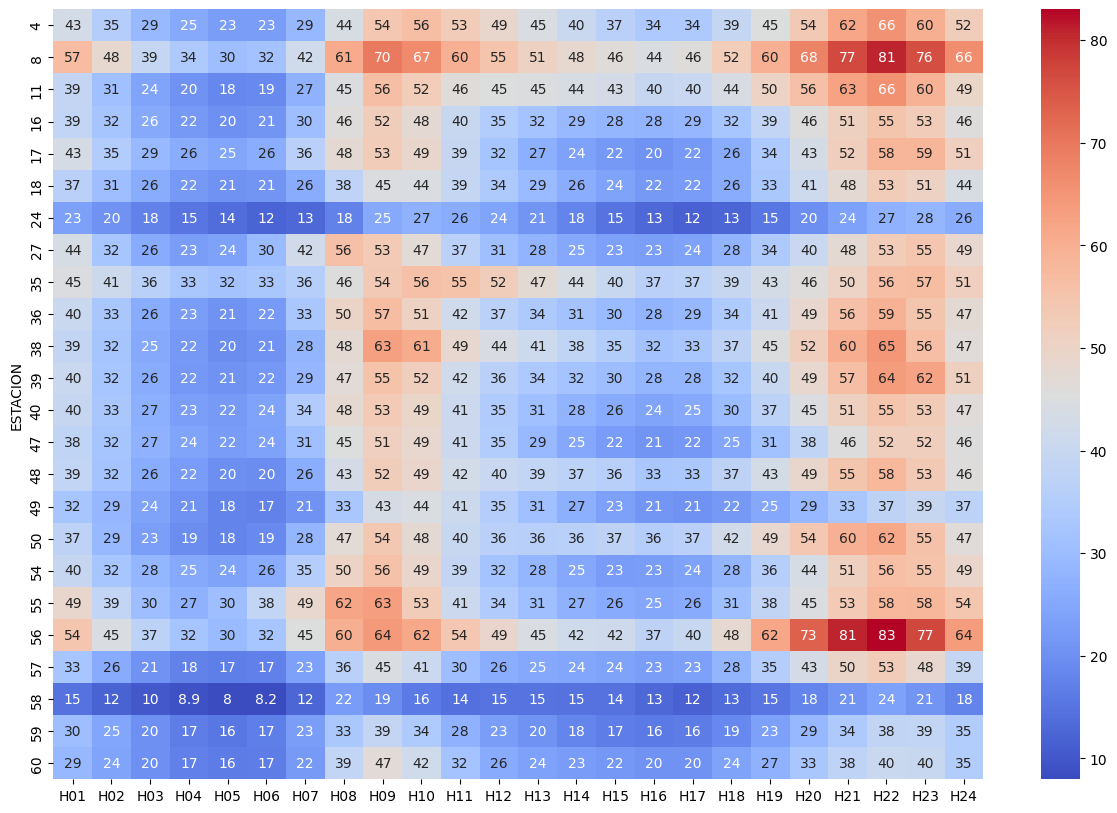

In [104]:
columnas_relevantes = [col for col in df_total.columns if col.startswith('H')]
df_agrupadas = df_total.groupby('ESTACION')[columnas_relevantes].mean()
# un grafico de calor para ver la relación entre las horas y las estaciones
plt.figure(figsize=(15, 10))
sns.heatmap(df_agrupadas, cmap='coolwarm', annot=True) # annot=True para que se muestren los valores en cada celda
plt.show()



Podemos sacar unas conclusiones rápidas a priori: vemos de manera sencilla en el anterior gráfico cómo dos estaciones resaltan por su medida tan baja de óxido de nitrógeno, que son la 24 (Casa de Campo) y 58 (El Pardo). Sabiendo que las demás estaciones están en ciertas partes de la ciudad de Madrid y que estas dos en concreto están en una zona muy verde y de parques, podemos concluir que la vegetación, el estar alejado del centro urbanístico de la ciudad y el no haber vehículos emitiendo gases afecta de manera considerable a una baja emisión de gases de óxido de nitrógeno.

Por su contraparte, podemos hacer una comparación inversa, viendo qué estaciones son las que más nivel de NO2 registran: 8 y 56. La primera, un lugar muy cercano a la M-30 de Madrid, autovía de uso elevado, y la segunda es en Plaza Elíptica, el sitio clave de la zona sur donde se concentra la mayor parte de tráfico de la ciudad por su cercanía con los pueblos de la zona sur de la capital. Por tanto, podemos concluir que el alto nivel de medición de dióxido de nitrógeno es debido a la contaminación de los vehículos cercanos a las estaciones. 

Se podrían llegar a sacar muchas más conclusiones haciéndolo por mes, días entre semana y semanas, etc.

#### **Plantea cómo harías un modelo de predicción a 3 días vista de los niveles de NO2. No hace falta que lo programes, aunque si te sientes más cómodo, puedes hacerlo. Por ejemplo, puedes plantear: posibles variables a introducir, profundidad histórica de los datos, técnicas de modelado a probar**

Pues vamos a hacer unos modelados de predicción a días vista y utilizaremos Prophet para la predicción en cuanto a los días vista. Hallamos la media de las medidas por horas y las agregamos a una columna nueva. También, juntamos los días, meses y año para formar una fecha, como nos indica Prophet en su [GitHub](https://facebook.github.io/prophet/docs/quick_start.html) para una buena utilización del modelo y renombramos las columnas.

In [105]:
df_prediccion = df_total.copy()
df_prediccion['media'] = df_total[columnas_relevantes].mean(axis=1)
# para la estación 4, vamos a hacer una predicción a 3 días vista
df_prediccion = df_prediccion[df_prediccion['ESTACION'] == 8]
df_prediccion['FECHA'] = df_prediccion['ANO'].astype(str) + '-' + df_prediccion['MES'].astype(str) + '-' + df_prediccion['DIA'].astype(str)
df_prediccion['FECHA'] = pd.to_datetime(df_prediccion['FECHA'])
df_prediccion = df_prediccion[['FECHA', 'media']]
new_names = {
    "FECHA": "ds",
    "media": "y",
}
df_prediccion.rename(columns=new_names, inplace=True)
df_prediccion['ds'] = df_prediccion['ds'].dt.tz_localize(None)


In [106]:
df_prediccion

,ds,y
248,2018-01-01,46.833333
250,2018-01-03,52.375000
251,2018-01-04,49.541667
252,2018-01-05,50.333333
253,2018-01-06,45.541667
...,...,...
271,2018-12-24,69.125000
272,2018-12-25,61.875000
275,2018-12-28,72.666667
276,2018-12-29,53.500000


Vamos a crear un gráfico para visualizar las medidas de NO2 a lo largo del año en la estación 8. 

In [107]:
x = df_prediccion["ds"]
y = df_prediccion["y"]

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y))

# el título
fig.update_layout(
    title_text="Serie temporal del la medición del NO2 en la estación 8 en 2018",
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1a", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    )
)

Ahora empezamos con la inicialización del modelo de Prophet. 

In [108]:
m = Prophet(seasonality_mode='multiplicative') # multiplicativo porque la estacionalidad no es constante

Entrenamos el modelo con nuestro dataset. 

In [109]:
m.fit(df_prediccion)

13:23:15 - cmdstanpy - INFO - Chain [1] start processing
13:23:15 - cmdstanpy - INFO - Chain [1] done processing


Ahora, vamos a generar un dataframe con los días que tenemos y los 3 días siguientes a predecir. 

In [110]:
future = m.make_future_dataframe(4)
future.tail()

,ds
337,2018-12-30
338,2018-12-31
339,2019-01-01
340,2019-01-02
341,2019-01-03


In [111]:
forecast = m.predict(future)

In [112]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()  # yhat es la predicción, yhat_lower y yhat_upper son los intervalos de confianza

,ds,yhat,yhat_lower,yhat_upper
337,2018-12-30,50.992994,33.683697,67.918153
338,2018-12-31,67.522585,51.984865,84.728910
339,2019-01-01,70.650605,52.869998,87.719720
340,2019-01-02,72.048476,56.035623,87.086112
341,2019-01-03,72.771393,55.264782,89.890699


In [113]:
plot_plotly(m, forecast)

Donde podemos ver que los valores predecidos tienen correlación con los datos de entrada y una previsión similar a lo que se ha ido dando a lo largo del tiempo. Los datos exactos son:

In [114]:
forecast[['ds', 'yhat']].tail()

,ds,yhat
337,2018-12-30,50.992994
338,2018-12-31,67.522585
339,2019-01-01,70.650605
340,2019-01-02,72.048476
341,2019-01-03,72.771393


Esta técnica de modelaje es útil teniendo todos los datos disponibles y sabiendo que no debería fluctuar en exceso el nivel de dióxido de nitrógeno. También, podríamos haber modelado una regresión lineal para hacer la predicción de los próximos 3 días, que habría llegado a una situación similar, pero sabiendo que deberíamos entrenar al modelo con un 80% de los datos y darle un 20% de los datos como test para que nos saque una predicción más fiable. Al fin y al cabo, son modelos que se ajustan de manera similar y para nada definitivos para sacar conclusiones. 

## *Objetivo 2: Arquitectura*

#### **Diseña una arquitectura para almacenar, limpiar, explotar y presentar estos datos. El uso de esta plataforma será:**
- **Dispondrá de información de niveles de NO2, las estaciones donde se han recogido y datos de temperaturas de Madrid**
- **Hay dos tipos de cargas de información:**
    - **Masivas, puntuales: sirven para hacer una carga inicial de datos. También, de forma esporádica, para corregir información capturada en tiempo real.**
    - **Incrementales. Los orígenes son: datos en tiempo real (actualizados cada hora) de contaminación; datos de temperaturas. Se capturarán consultando alguna API de servicios metereológicos.**
- **La explotación será:**
    - **Vía API: los usuarios de la plataforma pueden consultar y descargar los datos por API.**
    - **Vía portal web: el equipo de Front diseñará un portal para permitir que los usuarios visualicen mapas de calor, gráficas de evolución, etc.**
    - **Modelo predictivo: el equipo de Data creará un modelo para predecir la contaminación de los próximos 3 días.**
    - **Análisis ad hoc: además, el equipo de Data necesita explorar y crear pequeños análisis ad hoc que puedan surgir. P.e. Prevemos que el Ayuntamiento nos asigne la tarea de medir el efecto de las medidas tomadas en la legislatura pasada: Madrid Central, restricciones los días de aviso de contaminación, etc.**
- **El volumen de los datos: profundidad histórica desde el año 2001.**
- **La cantidad de usuarios: 500-1000 usuarios diarios.**



Tendremos que abordar esta propuesta con vistas a futuro, por lo que se tendrá que diseñar una arquitectura basada en servicios en la nube que aproveche herramientas de almacenamiento, procesamiento y visualización de datos. Lo voy a basar en Azure que es lo que más conozco, aunque si tuviera que implantarlo yo lo haría en GCP, ya que (opinión personal) no querría seguir utilizando Azure:


**Arquitectura de la plataforma de datos medioambientales para Madrid**

**1. Ingesta de datos:**
- **Cargas masivas y puntuales:**
  - Utilizar servicios de almacenamiento en Azure Blob Storage para guardar archivos .CSV o .parquet (sobre todo estos ya que son más útiles y eficaces).
  - Configurar un proceso de ETL en Azure Data Factory para extraer los datos desde el Blob Storage, limpiar y transformar los datos utilizando Apache Spark eliminando inconsistencias, valores nulos, duplicados y aplicar validaciones antes de cargarlos en la base de datos principal de Azure Synapse.

- **Cargas incrementales:**
  - Configurar conectores para acceder a las APIs de servicios meteorológicos y obtener datos en tiempo real utilizando Azure Logic Apps.
  - Programar una ingesta periódica para extraer los datos actualizados cada hora con Data Factory con Pipelines ejecutadas en intervalos regulares conectádose a las APIs meteorológicas y almacenando los datos en el mismo almacenamiento de las cargas masivas.

**2. Almacenamiento de datos:**
- **Base de datos principal:**
  - Sería ideal utilizar una base de datos NoSQL como MongoDB para almacenar los datos históricos y en tiempo real, dado el volumen de datos y por si es necesaria la escalabilidad.

**3. Explotación de datos:**
- **API:**
  - Desplegar una API RESTful con Azure API Management para permitir a los usuarios consultar y descargar datos de manera segura.
  - Implementar autenticación y autorización utilizando Azure Active Directory para garantizar la seguridad de los datos.

- **Portal web:**
  - Desarrollar un portal web con tecnologías como React.js o Angular.js para que los usuarios puedan visualizar mapas de calor, gráficas de evolución, etc.
  - Integrar bibliotecas de visualización de datos como D3.js o Plotly para crear visualizaciones interactivas y fáciles de entender.

- **Modelo predictivo:**
  - Utilizar bibliotecas de aprendizaje automático como TensorFlow, Scikit-learn, PyTorch o Prophet para crear un modelo predictivo de contaminación para los próximos 3 días.
  - Desplegar este modelo en Azure Machine Learning para facilitar su acceso a través de la API.

- **Análisis *ad hoc*:**
  - Configurar un entorno de análisis de datos utilizando Jupyter Notebooks o Google Colab para que el equipo de Data pueda explorar y crear análisis *ad hoc*.
  - Utilizar bibliotecas de análisis de datos como Pandas y NumPy para manipulación y procesamiento de datos.

**4. Monitoreo y alerta temprana:**
  - Implementar un sistema de monitoreo continuo de la calidad del aire y las condiciones meteorológicas utilizando servicios en la nube como Azure Monitor o Google Cloud Monitoring.
  - Este sistema detectará niveles anormales de contaminación o condiciones climáticas adversas y generará alertas automáticas para informar a las autoridades y al público en general.


Un sistema de arquitectura creado así sería robusto, tendría sus partes separadas de gestionar por gente especializada y sería eficaz de cara al futuro. Es una propuesta en Azure, que es lo que más manejo, pero de forma ideal lo montaría en GCP. 